
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling

from functions import wrangle

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import permutation_importance

from category_encoders import OneHotEncoder

from xgboost import XGBClassifier

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

import shap

# Read in data

In [2]:
import os
from pathlib import Path

__location__ = Path(os.getcwd()).parent
__data_dir__ = __location__ / "data"

df = pd.read_csv(str(__data_dir__) + '/anime.csv')

# Clean Data

In [3]:
df = wrangle(df)

In [4]:
df.head(1)

,type,source,episodes,duration,rating,studio,num_related,hentai/romance,sports,youth,adventure/psychological,drama,fantasy/sci-fi,comedy,military,misc,Unknown,class
0,TV,Manga,12,21-30,PG-13 - Teens 13 or older,other,2,True,False,True,False,False,True,True,False,False,False,Really good


In [5]:
df['class'].unique()

array(['Really good', 'OK', 'Questionable', 'Bad'], dtype=object)

# TTS

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('class',axis=1),df['class'],
                                                 random_state=42, test_size=.2)

# Baseline

In [7]:
baseline = max(y_train.value_counts(normalize=True))

# Logistic Regression Model

In [8]:
log = make_pipeline(OneHotEncoder(use_cat_names=True), LogisticRegressionCV(n_jobs=-1,random_state=42))

In [9]:
log.fit(X_train,y_train);

### Metrics

In [10]:
print(f"Baseline: {baseline}\n")
print(f"Train Score: {log.score(X_train,y_train)}")
print(f"Test Score: {log.score(X_test,y_test)}")

Baseline: 0.4348932837282162

Train Score: 0.6356961033875074
Test Score: 0.6342991386061081


In [11]:
print(classification_report(y_test, log.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.76      0.88      0.82      1123
          OK       0.42      0.42      0.42       501
Questionable       0.41      0.20      0.27       477
 Really good       0.63      0.72      0.67       453

    accuracy                           0.63      2554
   macro avg       0.55      0.55      0.54      2554
weighted avg       0.60      0.63      0.61      2554



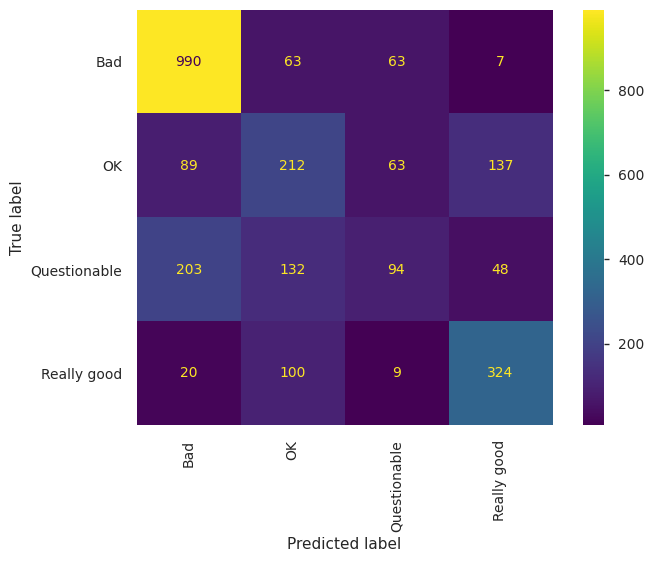

In [12]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(log, X_test, y_test, values_format='.0f', xticks_rotation='vertical')

## Feature Importance

In [13]:
result = permutation_importance(log, X_test, y_test, 
                                n_repeats=5, random_state=42)

feat_imp = pd.DataFrame({'feature': X_test.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})

feat_imp.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
4,rating,0.061,0.002496
6,num_related,0.057,0.003734
1,source,0.047,0.002888
3,duration,0.024,0.003525
0,type,0.021,0.004721
5,studio,0.014,0.003957
7,hentai/romance,0.010,0.000470
13,comedy,0.006,0.002451
9,youth,0.005,0.002915
11,drama,0.004,0.001624


# LogReg Hyperparam

# Random forest Base Model

In [14]:
forest = make_pipeline(OneHotEncoder(use_cat_names=True),RandomForestClassifier(n_jobs=-1,random_state=42))

In [15]:
forest.fit(X_train,y_train);

### Metrics

In [16]:
print(f"Baseline: {baseline}\n")
print(f"Train Score: {forest.score(X_train,y_train)}")
print(f"Test Score: {forest.score(X_test,y_test)}")

Baseline: 0.4348932837282162

Train Score: 0.964362639514392
Test Score: 0.6554424432263116


In [17]:
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.79      0.87      0.83      1123
          OK       0.47      0.44      0.46       501
Questionable       0.42      0.32      0.36       477
 Really good       0.67      0.72      0.69       453

    accuracy                           0.66      2554
   macro avg       0.59      0.59      0.59      2554
weighted avg       0.64      0.66      0.64      2554



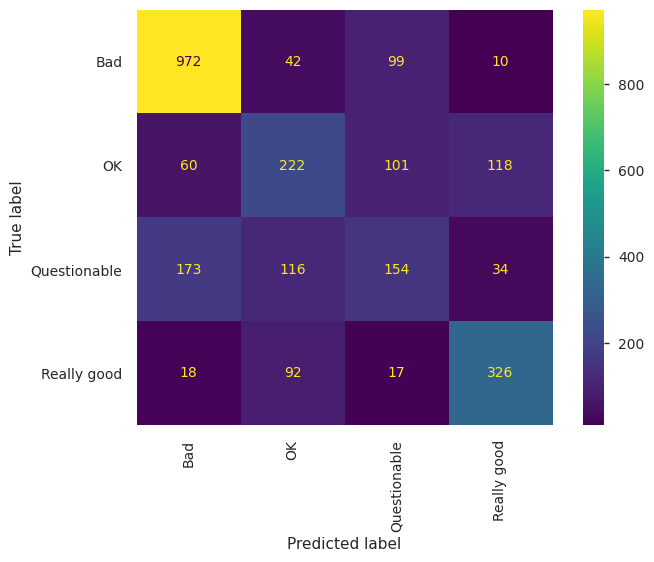

In [18]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(forest, X_test, y_test, values_format='.0f', xticks_rotation='vertical')

## Feature Importance

In [19]:
result = permutation_importance(forest, X_test, y_test, 
                                n_repeats=5, random_state=42)

feat_imp = pd.DataFrame({'feature': X_test.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})

feat_imp.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
4,rating,0.091,0.002913
1,source,0.070,0.005221
6,num_related,0.060,0.002786
3,duration,0.053,0.005109
0,type,0.015,0.004501
2,episodes,0.015,0.002905
5,studio,0.011,0.003472
12,fantasy/sci-fi,0.011,0.003701
13,comedy,0.008,0.004367
9,youth,0.006,0.003291


# Random Forest Hyperparam

# XGBClassifier Base model

In [20]:
xgb = make_pipeline(OneHotEncoder(use_cat_names=True),
                    XGBClassifier(n_jobs=-1,random_state=42))

In [21]:
xgb.fit(X_train,y_train);

In [42]:
xgb.named_steps['xgbclassifier']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
dir(XGBClassifier)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'apply',
 'coef_',
 'evals_result',
 'feature_importances_',
 'fit',
 'get_booster',
 'get_num_boosting_rounds',
 'get_params',
 'get_xgb_params',
 'intercept_',
 'load_model',
 'predict',
 'predict_proba',
 'save_model',
 'score',
 'set_params']

### Metrics

In [22]:
print(f"Baseline: {baseline}\n")
print(f"Train Score: {xgb.score(X_train,y_train)}")
print(f"Test Score: {xgb.score(X_test,y_test)}")

Baseline: 0.4348932837282162

Train Score: 0.8162326218915215
Test Score: 0.6554424432263116


In [23]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

         Bad       0.78      0.87      0.82      1123
          OK       0.47      0.47      0.47       501
Questionable       0.43      0.30      0.35       477
 Really good       0.68      0.71      0.70       453

    accuracy                           0.66      2554
   macro avg       0.59      0.59      0.58      2554
weighted avg       0.64      0.66      0.64      2554



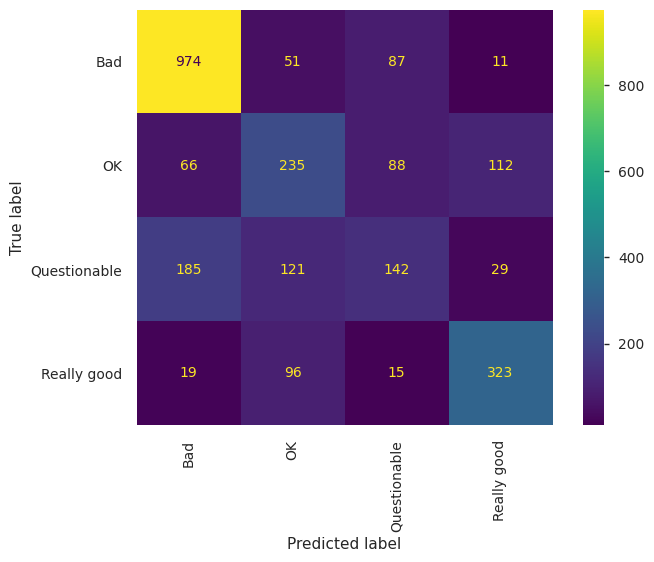

In [24]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(xgb, X_test, y_test, values_format='.0f', xticks_rotation='vertical')

## Feature Importance

In [25]:
result = permutation_importance(xgb, X_test, y_test, 
                                n_repeats=5, random_state=42)

feat_imp = pd.DataFrame({'feature': X_test.columns,
                   'importances_mean': np.round(result['importances_mean'], 3),
                   'importances_std': result['importances_std']})

feat_imp.sort_values(by='importances_mean', ascending=False)

,feature,importances_mean,importances_std
6,num_related,0.073,0.003606
1,source,0.073,0.007318
4,rating,0.058,0.005433
3,duration,0.040,0.003668
5,studio,0.026,0.003223
0,type,0.021,0.003204
2,episodes,0.019,0.004148
9,youth,0.009,0.004161
7,hentai/romance,0.008,0.002033
13,comedy,0.008,0.002940


# XGBClassifier Hyperparam

# XGBClassifier pdp

In [26]:
plt.rcParams['figure.dpi'] = 72

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


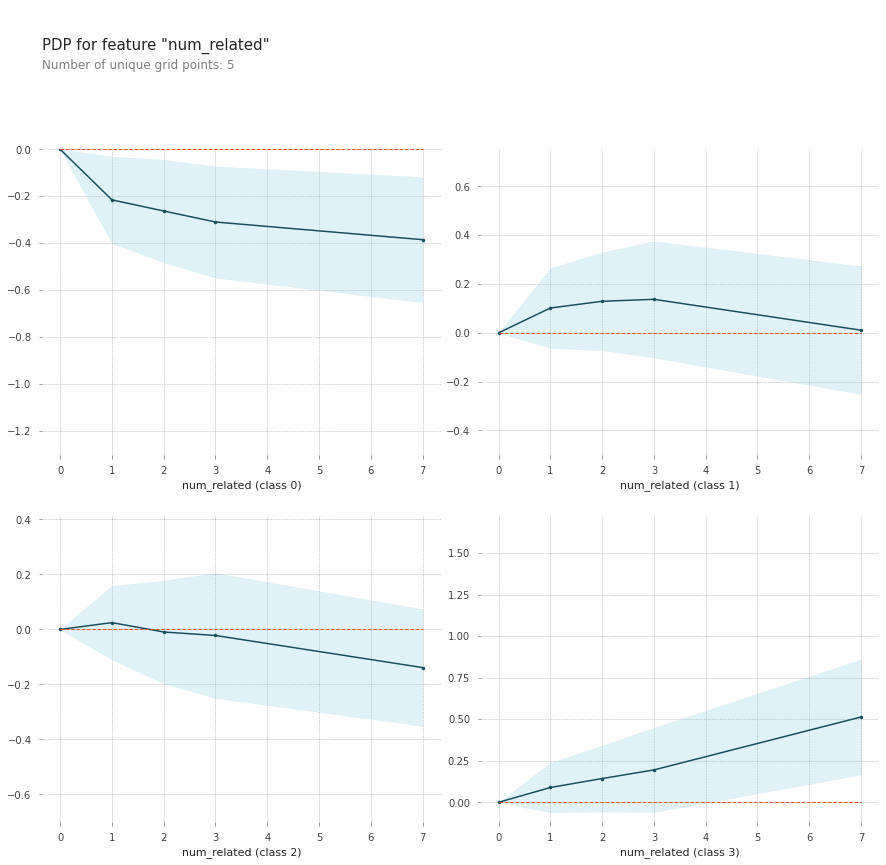

In [27]:
feature = 'num_related'

isolated = pdp_isolate(
    model=xgb,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature);

In [72]:
from sklearn.inspection import plot_partial_dependence

#plot_partial_dependence(xgb,X_test,features=feature,target='Really good')#there's an issue with the feature

In [28]:
'''features = ['num_realted', '']

interaction = pdp_interact(
    model=xgb, 
    dataset=X_test, 
    model_features=X_test.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);'''
#cant do because i dont have multiple numeric features
df['class'].unique()

array(['Really good', 'OK', 'Questionable', 'Bad'], dtype=object)

# Forest Shapley

In [30]:
encoder = OneHotEncoder(use_cat_names=True)
train_trans = encoder.fit_transform(X_train)
test_trans = encoder.transform(X_test)

In [31]:
row = test_trans.iloc[[0]]

In [32]:
forest = RandomForestClassifier(n_jobs=-1,random_state=42)
forest.fit(train_trans,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
explainer = shap.TreeExplainer(forest)

In [34]:
shap_values = explainer.shap_values(row)

In [35]:
shap.initjs()

In [71]:
shap.force_plot(
    base_value=explainer.expected_value[0],
    shap_values=shap_values[0],
    features=row,
    link='logit'
)